In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp


seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi

In [4]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def fvec(self, t, x):
    return self.forward(x)

In [5]:
import time
input_size = 4
output_size = 4
hidden_size = 200

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mlp_net = MLP(input_size, hidden_size, output_size).to(device)

  num_epochs = 2000
  criterion = nn.MSELoss()
  optimizer = optim.Adam(params=mlp_net.parameters(), lr=0.001)

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    mlp_net.train()
    total_loss = 0.0
    eval_loss = 0.0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mlp_net(data.to(device))
      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
    total_loss = total_loss/i

    num_correct = 0
    num_data = 0
    mlp_net.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mlp_net(data.to(device))
      target = target.to(device)

      eval_loss = eval_loss+criterion(output,target).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/node_ms_{}".format(trial)
  torch.save(mlp_net.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:6.079296436158224e-07,evaluation loss:2.964163599017411e-07
2000/2000 training loss:3.6712864979868246e-07,evaluation loss:1.7046425497824204e-07
2000/2000 training loss:4.942243482424842e-07,evaluation loss:2.1542091204196369e-07
2000/2000 training loss:7.351072447018172e-07,evaluation loss:4.629019684898594e-07
2000/2000 training loss:5.584046170606829e-07,evaluation loss:4.544194467825946e-07
2000/2000 training loss:4.3378303300984575e-07,evaluation loss:5.418349047658921e-07
2000/2000 training loss:7.301688527054984e-07,evaluation loss:1.4919274917701841e-06
2000/2000 training loss:3.0817582517951036e-07,evaluation loss:1.5797202905787345e-07
2000/2000 training loss:1.788375820428681e-07,evaluation loss:1.2725792917223088e-07
2000/2000 training loss:3.6311056300712175e-07,evaluation loss:3.8535527693284164e-07
train_loss:4.776870359364334e-07, std: 1.7294152542632718e-07
test_loss:4.303970573893423e-07, std: 3.7957436987022775e-07
computation_time:716.517057

In [7]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A) `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.33934223 0.36219116 0.44109076 0.66546418]


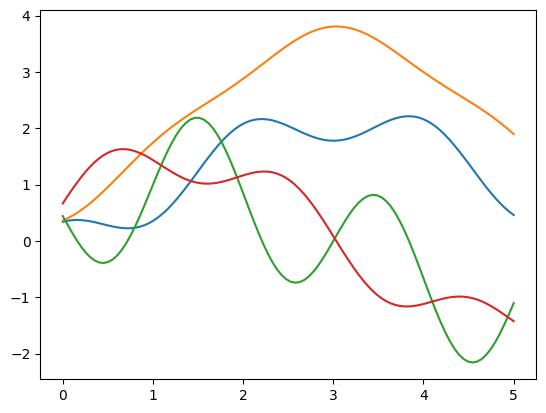

energy_error0:-1.216807639979446


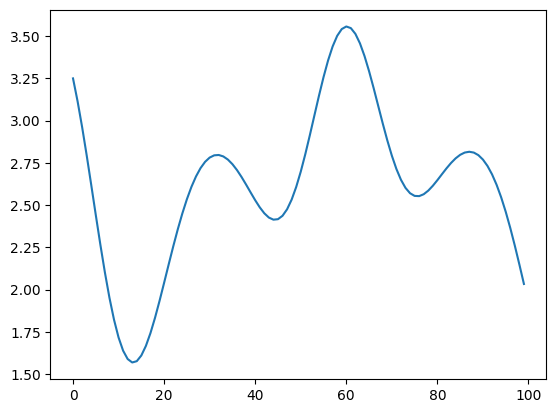

[0.70399322 0.90125315 0.02954776 0.49957685]


/tmp/ipykernel_36783/808807249.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_36783/808807249.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


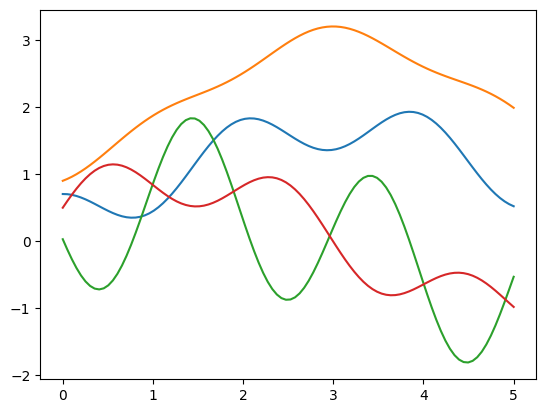

energy_error1:-0.5302419114694181


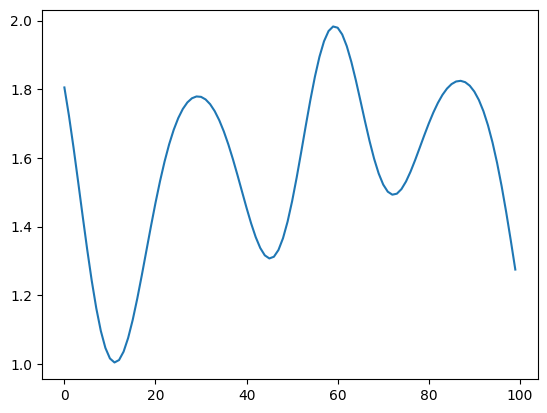

[0.44740635 0.49796745 0.72791378 0.12088727]


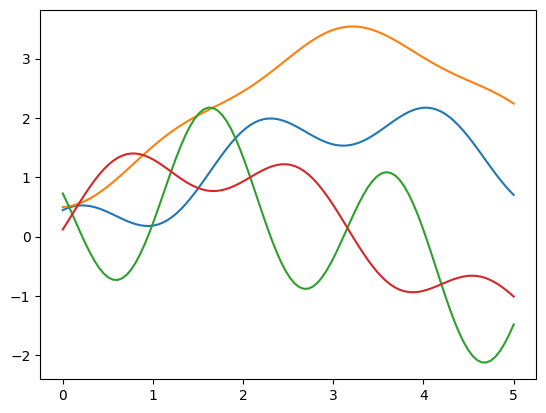

energy_error2:-0.7690936130765924


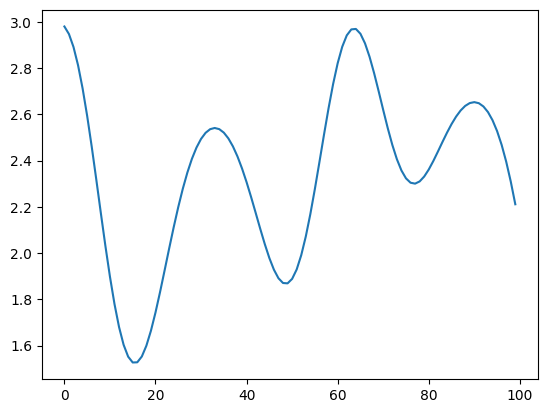

[0.92729446 0.15537564 0.67088593 0.02294421]


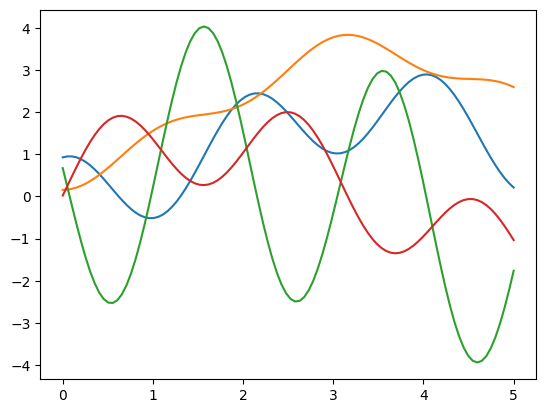

energy_error3:-0.5536094166333481


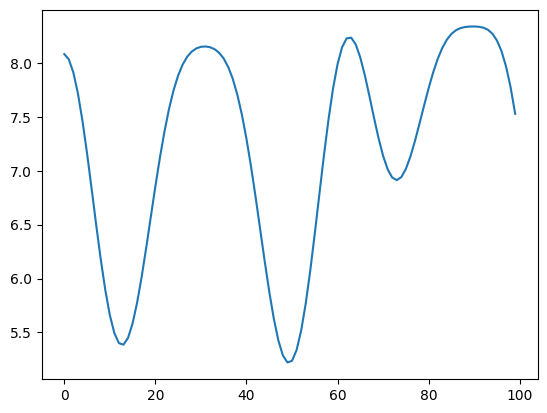

[0.26289127 0.56600179 0.43882605 0.79554568]


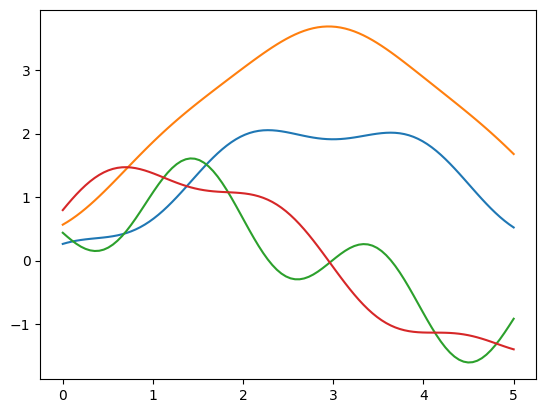

energy_error4:-0.9716869882092802


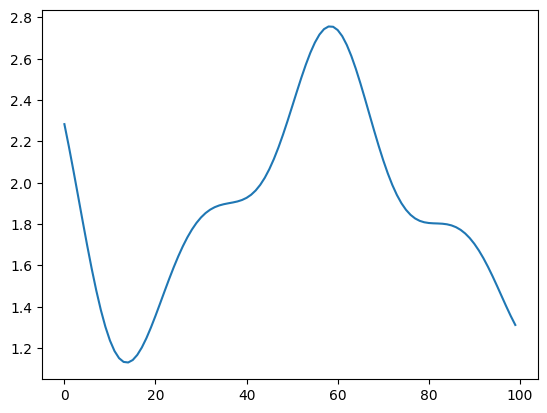

[0.04651726 0.15780542 0.63263753 0.5602046 ]


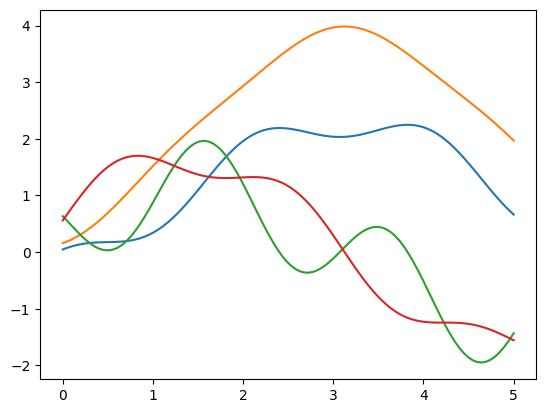

energy_error5:-1.5801621090277225


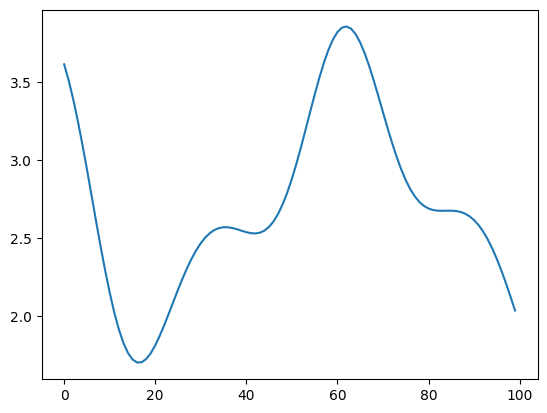

[0.21905157 0.51230553 0.8936477  0.5353286 ]


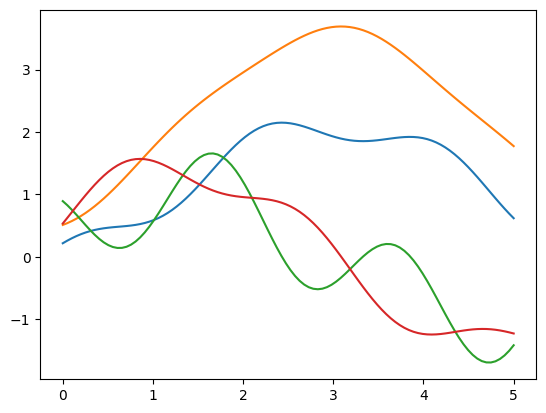

energy_error6:-0.9839599637897021


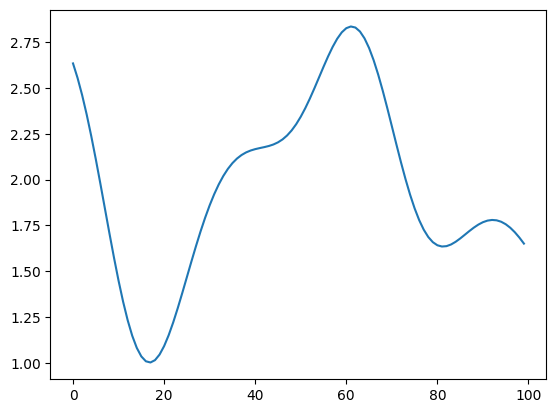

[0.36413251 0.70455736 0.42702708 0.50627118]


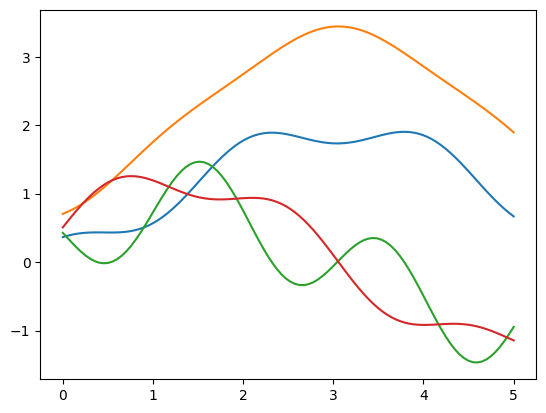

energy_error7:-0.7775500481745163


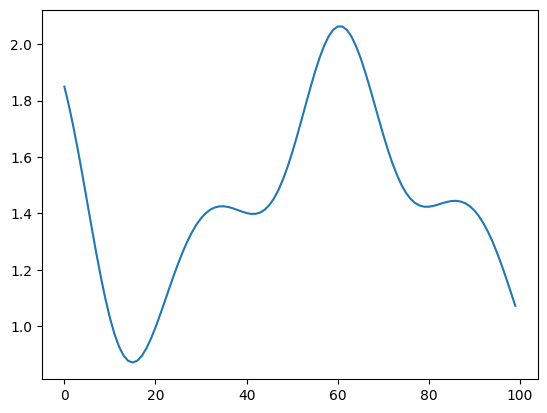

[0.67855903 0.87849157 0.03212936 0.18337338]


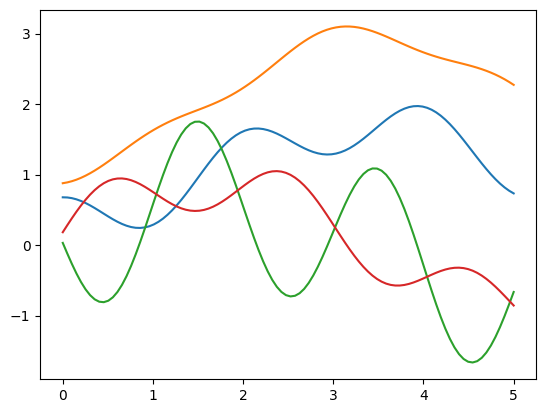

energy_error8:-0.5277093355336371


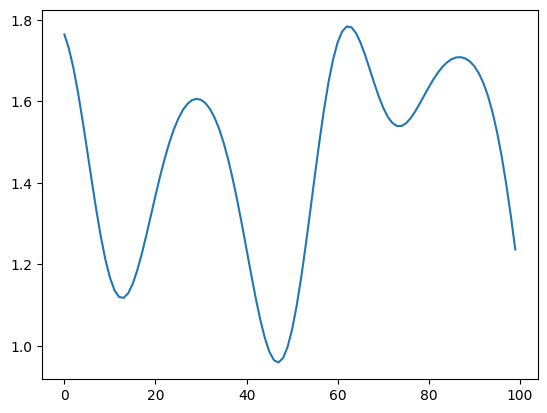

[0.61195673 0.75961104 0.57334028 0.91612824]


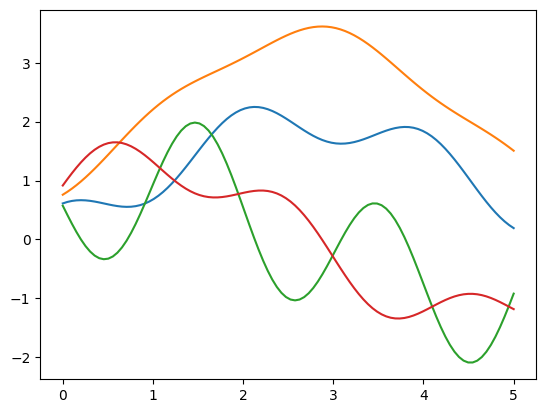

energy_error9:-0.4196977603657168


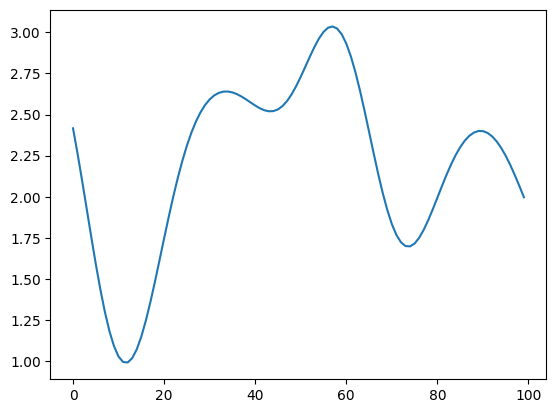

eq_error:[np.float64(-1.216807639979446), np.float64(-0.5302419114694181), np.float64(-0.7690936130765924), np.float64(-0.5536094166333481), np.float64(-0.9716869882092802), np.float64(-1.5801621090277225), np.float64(-0.9839599637897021), np.float64(-0.7775500481745163), np.float64(-0.5277093355336371), np.float64(-0.4196977603657168)]
eq_error:0.8330518786259379, std: 0.3447439483028103


In [8]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
eq_error = []

for trial in range(num_trials):
  mlp_net.load_state_dict(torch.load("./model/node_ms_{}".format(trial), map_location="cpu"))
  mlp_net.eval()
  teval = torch.linspace(0.0,5.0,100)
  #x0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  x0 = np.random.rand(4)
  print(x0)
  dt = teval[1]-teval[0]
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  mlp_net.eval()
  mlp_net.cpu()
  def fvec_np(x,t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = mlp_net.forward(x).squeeze(0)
      output = torch.matmul(A, output)
      output = output.squeeze(0)
      return output.detach().cpu().numpy()
  res = scipy.integrate.odeint(fvec_np,x0,teval)
  plt.plot(teval,res[:,0])
  plt.plot(teval,res[:,1])
  plt.plot(teval,res[:,2])
  plt.plot(teval,res[:,3])
  plt.show()

  energy = np.square(res[:,2])/(2*m1) + np.square(res[:,3])/(2*m2) + k1*np.square((res[:,0]-l1))/2 + k2*np.square((res[:,1]-res[:,0]-l2))/2
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)

print("eq_error:{}".format(eq_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))

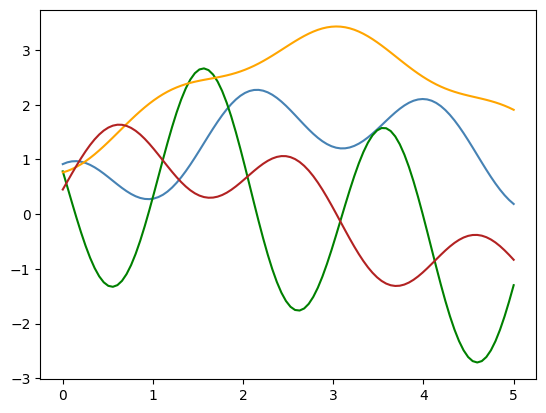

In [9]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

x1_init = np.random.randn(1)
x2_init = np.random.randn(1)
#print(x1)
v1_init = np.random.randn(1)
v2_init = np.random.randn(1)
state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  dv1dt = sol['y'][0], sol['y'][1]
  dv2dt = sol['y'][2], sol['y'][3]
  p1 = dv1dt[0]
  p2 = dv1dt[1] 
  v1 = dv2dt[0]
  v2 = dv2dt[1]
  plt.plot(tval, p1, 'steelblue')
  plt.plot(tval, v1, 'g')
  plt.plot(tval, p2, 'orange')
  plt.plot(tval, v2, 'firebrick')
  plt.show()